In [32]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Drawing Utils

In [2]:
def ImageLayout(dic, double=False, save=False, path='Demo.png'):
    ''' 
        Plots a keyboard layout using Images/BaseIndexing as the indexes
    '''
    dx = 55
    dy = 130
    dnext = 135
    dright = 60
    img = plt.imread('Images/BlankLayout.png')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    it = 0
    iniX = 180
    iniY = 250

    X = iniX
    Y = iniY
    for i in range(10):
        X2 = X
        Y2 = Y
        for j in range(4):
            ax.text(X2, Y2, str(dic[it]))
            it += 1
            if double == True:
                ax.text(X2+dright, Y2, str(dic[it]))
            it+=1
            X2 += dx
            Y2 += dy
        X+= dnext

    X2 = X
    Y2 = Y
    for j in range(3):
        ax.text(X2, Y2, str(dic[it]))
        it += 1
        if double == True:
            ax.text(X2+dright, Y2, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext


    X2 = X
    Y2 = Y
    for j in range(2):
        ax.text(X2, Y2, str(dic[it]))
        it += 1
        if double == True:
            ax.text(X2+dright, Y2, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext

    X2 = X +dx
    Y2 = Y + dy
    ax.text(X2, Y2, str(dic[it]))
    it += 1
    if double == True:
        ax.text(X2+dright, Y2, str(dic[it]))
    it+=1

    X2 = iniX-dnext
    Y2 = iniY
    ax.text(X2, Y2, str(dic[it]))
    it += 1
    if double == True:
        ax.text(X2+dright, Y2, str(dic[it]))
    it+=1

    if save == True:
        fig.savefig(path, dpi= 1000)
    


# Objective Function

In [3]:
class FunctionHelper:
    ''' Helper Functions to determine the weight of each keyboard position
    '''
    def __init__(self, charMap, charCount, pairCount):
        ''' 
            initializes enumerations
        '''
        self.charMap = charMap
        self.charCount = charCount
        self.pairCount = pairCount
        self.FINGERS_NAME = ['pinky', 'ring', 'middle', 'index', 'thumb', 'none', 'unknown']
        self.FINGERS = [0,1,2,3,4,5,6]
        self.FINGERS_WEIGHT = [3,2, 2, 1, 0, 0, 'Unknown']
        self.HAND = ['left', 'right', 'none', 'Unknown']
        self.COLUMNS = [0,1,2,3,'Unknown']
        self.COLUMNS_WEIGHT = [2,1,0,1.5,'Unknown']
        self.MOVEMENT = [0, 1, 2, 3, 'Unknown']

    def getCSVIndex(self,c):
        return self.charMap[c]
    
    def GetFinger(self,index):
        '''
        Returns the finger that corresponds to the key based on classic touchtyping
        '''
        if(index >= 0 and index <= 9):
            return self.FINGERS[0]
        if(index >= 10 and index <= 17):
            return self.FINGERS[1]
        if(index >= 18 and index <= 25):
            return self.FINGERS[2]
        if(index >= 26 and index <= 41):
            return self.FINGERS[3]
        if(index >= 42 and index <= 55):
            return self.FINGERS[3]
        if(index >= 56 and index <= 63):
            return self.FINGERS[2]
        if(index >= 64 and index <= 71):
            return self.FINGERS[1]
        if(index >= 72 and index <= 93):
            return self.FINGERS[0]
        return self.FINGERS[-1]

    def GetHand(self, index):
        '''
        Returns the hand that corresponds to the key based on classic touchtyping
        '''
        if(index >= 0 and index <= 41):
            return self.HAND[0]
        if(index >= 92 and index <= 93):
            return self.HAND[0]
        if(index >= 42 and index <= 91):
            return self.HAND[1]
        return self.HAND[-1]

    def ShiftHand(self, index):
        '''
        Returns wether that key must have the shift key pressed, and which hand presses that key
        '''
        if(index%2 == 0):
            return self.HAND[2]
        if(self.GetHand(index) == self.HAND[0]):
            return self.HAND[1]
        if(self.GetHand(index) == self.HAND[1]):
            return self.HAND[0]
        return self.HAND[-1]

    def Column(self, index):
        '''
        Returns the column of a key
        '''
        if(index <= 85):
            ii = index%8
            if(ii == 0 or ii == 1):
                return self.COLUMNS[0]
            if(ii == 2 or ii == 3):
                return self.COLUMNS[1]
            if(ii == 4 or ii == 5):
                return self.COLUMNS[2]
            if(ii == 6 or ii == 7):
                return self.COLUMNS[3]
        
        if(index > 85):
            ii = index%8
            if(ii == 0 or ii == 1):
                return self.COLUMNS[1]
            if(ii == 2 or ii == 3):
                return self.COLUMNS[1]
            if(ii == 4 or ii == 5):
                return self.COLUMNS[0]
            if(ii == 6 or ii == 7):
                return self.COLUMNS[0]
        return self.COLUMNS[-1]

    def LateralMovement(self, index):
        ''' 
            Returns how much lateral distance a finger moves from its base position to that key
        '''
        index = index - (index%2)
        if(index == 0):
            return self.MOVEMENT[1]
        if(index == 92):
            return self.MOVEMENT[2]
        if(index == 90):
            return self.MOVEMENT[3]
        if(index >= 86 and index <= 88):
            return self.MOVEMENT[2]
        if(index >= 80 and index <= 84):
            return self.MOVEMENT[1]
        if(index >= 34 and index <= 46):
            return self.MOVEMENT[1]
        if(index >= 0 and index <= 93):
            return self.MOVEMENT[0]
        return self.MOVEMENT[-1]

    def WeightIndex(self, index):
        '''
            Is a function that determines how hard it is to reach a key,
            based on the distance travel from the home row and the dexterity of a 
            finger
        '''
        assert (index <= 93)
        finger = self.GetFinger(index)
        wFinger = self.FINGERS_WEIGHT[finger]
        lat = self.LateralMovement(index)
        colW = self.COLUMNS_WEIGHT[self.Column(index)]
        return ((lat+colW)**2)*wFinger 
    
    def LeftShift(self, indexA):
        '''
        Returns how hard it is to press the LeftShift button and then a 'indexA' key
        If different hands are used, then it is not hard
        It uses the distance between keys and wether the same finger presses both keys
        '''
        ha = self.GetHand(indexA)
        hb = self.GetHand(6)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(6)
        colb = self.Column(6)
        latb = self.LateralMovement(3)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])

    def RightShift(self, indexA):
        '''
        Returns how hard it is to press the RightShift button and then a 'indexA' key
        If different hands are used, then it is not hard
        It uses the distance between keys and wether the same finger presses both keys
        '''
        ha = self.GetHand(indexA)
        hb = self.GetHand(78)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(78)
        colb = self.Column(78)
        latb = self.LateralMovement(78)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])

    def WeightPairWise(self, indexA, indexB):
        '''
        Returns how hard it is to press two consecutive keys
        If different hands are used, then it is not hard
        It uses the distance between keys and wether the same finger presses both keys
        It takes into consideration shift keys
        '''
        if(indexA%2 == 1 and indexB%2 == 1):
            iA = indexA-1
            iB = indexB-1
            ans = self.WeightPairWise(iA, iB)
            ha = self.GetHand(indexA)
            if(ha == self.HAND[1]):
                ans += self.LeftShift(iB)
            else:
                ans += self.RightShift(iB)
            
            hb = self.GetHand(indexB)
            if(hb == self.HAND[1]):
                ans += self.LeftShift(iA)
            else:
                ans += self.RightShift(iA)
            return ans
        if(indexA%2 == 1):
            iA = indexA-1
            iB = indexB
            ans = self.WeightPairWise(iA, iB)
            ha = self.GetHand(indexA)
            if(ha == self.HAND[1]):
                ans += self.LeftShift(iB)
            else:
                ans += self.RightShift(iB)
            return ans
        if(indexB%2 == 1):
            return self.WeightPairWise(indexB, indexA)


        ha = self.GetHand(indexA)
        hb = self.GetHand(indexB)
        if(ha != hb): return 0
        fa = self.GetFinger(indexA)
        cola = self.Column(indexA)
        lata = self.LateralMovement(indexA)
        fb = self.GetFinger(indexB)
        colb = self.Column(indexB)
        latb = self.LateralMovement(indexB)
        if(fa == fb):
            return ((cola-colb)**2+(lata-latb)**2) * 10 * self.FINGERS_WEIGHT[fa]
        return ((cola-colb)**2) * (self.FINGERS_WEIGHT[fa] + self.FINGERS_WEIGHT[fb])
    

In [4]:
def ObjectiveFunction(X, helper):
    '''
    Calculates the 'freq of each character' * 'how difficult it is to reach that character' 
    + 'freq of each pair of characters' * 'how difficult it is to type the two characters in sequence' 
    '''
    ans = 0
    chars = 0
    XIndex = [helper.getCSVIndex(x) for x in X]
    for i, x in enumerate(XIndex):
        ans += helper.charCount[x]*helper.WeightIndex(i)
        chars += helper.charCount[x]
    for i,x in enumerate(XIndex):
        for j,y in enumerate(XIndex):
            ans += helper.pairCount[x][y]*helper.WeightPairWise(i,j)
            chars += helper.pairCount[x][y]
    return ans/chars
        

In [5]:
validChars = 'pPyYfFgGcCrRlLaAoOeEuUiIdDhHtTnNsSqQjJkKxXbBmMwWvVzZ$&[{}(=*)+]!#~%7531902468`;,./@\\:<>?^|-\'_"\t\n '
allChars = dict(zip(validChars,np.arange(len(validChars))))
charCountCSV = np.array(pd.read_csv('Dataset/CharCount.csv').values)[:,2]
pairCountCSV = np.array(pd.read_csv('Dataset/PairCount.csv').values)[:,1:]

In [6]:
helper = FunctionHelper(allChars, charCountCSV, pairCountCSV)

# Genetic Algorithm Functions

26 lowercase letters
52 letters
94 characters

In [7]:

def GenerateRandomIndividual(gen, allChars, validChars):
    '''
    A solution is a permutation of 93 numbers, with th restriction that lowercase and 
    uppercase letters go in the same key
    '''
    individual = np.ones(94)*-1
    lowercase = gen.permutation(47)[:26]
    lowercase *= 2
    for i, x in zip(range(0,52,2), lowercase):
        individual[x] = i
        individual[x+1] = i+1
    
    restChars = gen.permutation(94-52)
    restChars += 52
    itInd = 0
    for x in restChars:
        while(individual[itInd] != -1):
            itInd+=1
        individual[itInd] = x
        itInd += 1
    ans = [validChars[int(x)] for x in individual]
    return np.array(ans)




In [8]:
def SwapMutation(X, gen, allChars, validChars):
    '''
    Swaps two keys (two complete keys, including shift characters)
    '''
    #Swap two keys
    a = int(gen.random()*47)
    b = int(gen.random()*47)
    a*=2
    b*=2
    a = int(a)
    b = int(b)
    aa = X[a]
    aa2 = X[a+1]
    X[a] = X[b]
    X[a+1] = X[b+1]
    X[b+1] = aa2
    X[b] = aa

    #Swap in same key
    '''
    Swaps characters within the same key
    Only applies to non-letter keys
    '''
    a = int(gen.random()*(47-26))
    a*=2
    for i, x in enumerate(X):
        if(a == 0 and allChars[x] >= 52):
            t = X[i]
            X[i] = X[i+1]
            X[i+1] = t
            break
        elif(allChars[x]>=52):
            a-=1
    return X


In [9]:
def CrossOver(pa, pb, rng, allChars, validChars):
    '''
    Simple crossover mantaining the conditions of the problem
    '''
    #print(pa, pb)
    div = int(rng.random()*47)
    div*=2
    son = pa.copy()
    son[:div] = pa[:div]
    dic = dict()
    for i in range(div):
        dic[pa[i]] = 1
    #print(div)
    extra = []
    extraLetter = []
    for j in range(div):
        if(dic.get(pb[j]) is None):
            if(allChars[pb[j]] < 52):
                extraLetter.append(pb[j])
            else:
                extra.append(pb[j])
    
    son[div:] = pb[div:]
    itExtra = 0
    itExtraLetter = 0
    #print(extra, extraLetter)
    for i in range(div, 94):
        if(dic.get(son[i]) is not None):
            #print(i, itExtra, itExtraLetter)
            if((i%2 == 0 and itExtraLetter < len(extraLetter) and dic.get(son[i+1]) != None) or itExtraLetter%2 == 1):
                son[i] = extraLetter[itExtraLetter]
                itExtraLetter+=1
            else:
                if itExtra >= len(extra):
                    return pa
                son[i] = extra[itExtra]
                itExtra += 1

    return son

# Run Experiment and Results

In [10]:
from GeneticAlgorithm import GeneticOptimization

In [11]:
randGen = np.random.default_rng(226154)
gen = GeneticOptimization(ObjectiveFunction, randGen, GenerateRandomIndividual, SwapMutation, CrossOver, allChars, validChars, helper = helper)
sol = gen.solve(40, 1000, .8, .2, 30)
sol 

{'X': array(['!', '|', '6', '<', 'n', 'N', 'k', 'K', 'q', 'Q', 'u', 'U', 'i',
        'I', 'h', 'H', 'y', 'Y', 'b', 'B', 'e', 'E', 'w', 'W', '2', '`',
        'g', 'G', 't', 'T', 'c', 'C', '0', '&', 'd', 'D', 'm', 'M', 'v',
        'V', '1', '7', '"', '*', 'o', 'O', '-', '[', '4', '\\', '(', ']',
        'a', 'A', 'l', 'L', 'x', 'X', '.', '8', 'r', 'R', ':', ';', '3',
        '{', 'f', 'F', 's', 'S', 'p', 'P', '9', '}', '+', '/', ',', '>',
        '_', '?', '^', "'", '=', '@', ')', '5', '#', '%', 'z', 'Z', '$',
        '~', 'j', 'J'], dtype='<U1'),
 'fun': 3.6225041057092557,
 'fun_call': 40040,
 'progress_fit': [11.195108476740558,
  10.911940932909479,
  9.755451577369197,
  9.755451577369197,
  9.755451577369197,
  8.499676542162833,
  8.063270668565776,
  7.994323041761506,
  7.88131487372264,
  7.711801860770976,
  7.468372277100637,
  7.4498202267468105,
  7.4498202267468105,
  7.147484036223556,
  7.147484036223556,
  7.147484036223556,
  7.147484036223556,
  7.147484036223556,


Text(0.5, 1.0, 'Solution')

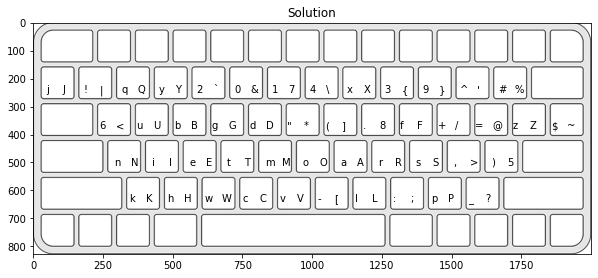

In [156]:
ImageLayout(sol['X'], True)
plt.gca().set_title('Solution')

Text(0.5, 1.0, 'Objective Function vs Iteration')

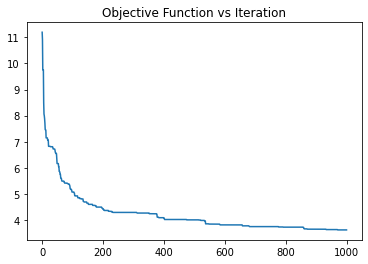

In [13]:
plt.plot(sol['progress_fit'])
plt.title('Objective Function vs Iteration')

In [14]:
qwertyLayout = '1!qQaAzZ2@wWsSxX3#eEdDcC4$rRfFvV5%tTgGbB6^yYhHnN7&uUjJmM8*iIkK,<9(oOlL.>0)pP;:/?-_[{\'"=+]}\\|`~'
dvorak = '1!\'"aA;:2@,<oOqQ3#.>eEjJ4$pPuUkK5%yYiIxX6^fFdDbB7&gGhHmM8*cCtTwW9(rRnNvV0)lLsSzZ[{/?-_]}=+\\|`~'
programmerDvorak = '&%;:aA\'"[7,<oOqQ{5.>eEjJ}3pPuUkK(1yYiIxX=9fFdDbB*0gGhHmM)2cCtTwW+4rRnNvV]6lLsSzZ!8/?-_#`@^\\|$~'
baseLayout = 'pPyYfFgGcCrRlLaAoOeEuUiIdDhHtTnNsSqQjJkKxXbBmMwWvVzZ$&[{}(=*)+]!#~%7531902468`;,./@\\:<>?^|-\'_"'
qwertyFit = ObjectiveFunction(qwertyLayout, helper)
dvorakFit = ObjectiveFunction(dvorak, helper)
programmerFit = ObjectiveFunction(programmerDvorak, helper)
print('QWERTY', qwertyFit)
print('dvorak', dvorakFit)
print('programmerDvorak', programmerFit)
print('ourLayout', sol['fun'])

QWERTY 9.627145681198524
dvorak 6.363957674763863
programmerDvorak 5.714991159235316
ourLayout 3.6225041057092557


In [15]:
#our solution is better (in terms of the objective function) by a considerable margin

Text(0.5, 1.0, 'QWERTY')

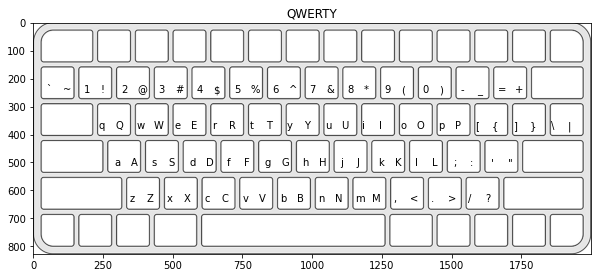

In [158]:
ImageLayout(qwertyLayout, double=True)
plt.gca().set_title('QWERTY')

Text(0.5, 1.0, 'Dvorak')

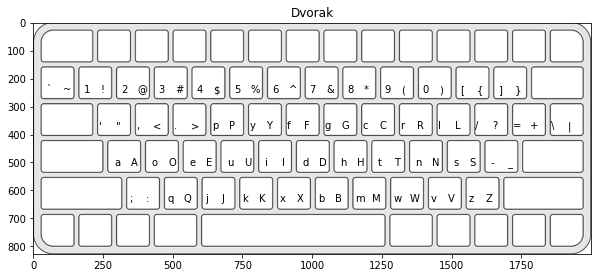

In [160]:
ImageLayout(dvorak, double=True)
plt.gca().set_title('Dvorak')

Text(0.5, 1.0, 'Programmer Dvorak')

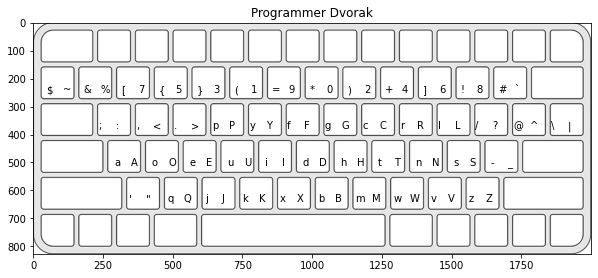

In [159]:
ImageLayout(programmerDvorak, double=True)
plt.gca().set_title('Programmer Dvorak')

Text(0.5, 1.0, 'Character Frecuency')

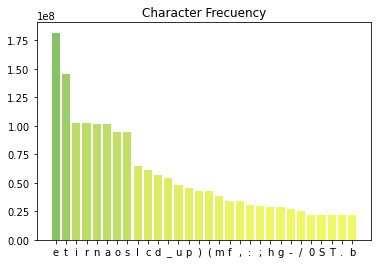

In [161]:
count = np.array((charCountCSV.copy())[:-3])
keys = np.array(list(allChars.keys())[:-3])
sort = np.argsort(count)
count = count[sort[-30:]]
keys = keys[sort[-30:]]
count = count[::-1]
keys = keys[::-1]

norm = np.linalg.norm(count)
norm = np.array(count/norm, dtype=np.float32)
lis = cm.summer_r(norm)

plt.bar(np.arange(30),count,tick_label=keys, color=lis)
plt.gca().set_title('Character Frecuency')

Text(0.5, 1.0, 'Pairwise Frecuency')

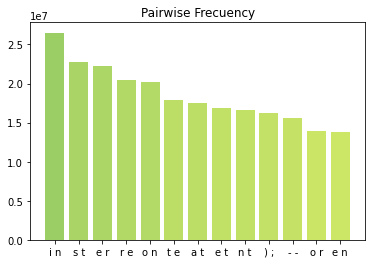

In [162]:
labels = []
values = []
a = list(allChars)[:94]
for i,x in enumerate(a):
    for j,y in enumerate(a):
        values.append(pairCountCSV[i][j])
        labels.append(x+' '+y)

count = np.array(values)
keys = np.array(labels)
sort = np.argsort(count)
ii = 13
count = count[sort[-1*ii:]]
keys = keys[sort[-1*ii:]]
count = count[::-1]
keys = keys[::-1]

norm = np.linalg.norm(count)
norm = np.array(count/norm, dtype=np.float32)
lis = cm.summer_r(norm)
plt.bar(np.arange(ii), count, tick_label = keys, color=lis)
plt.gca().set_title('Pairwise Frecuency')

In [143]:
def HeatmapLayout(dic, allChars, charCount, double=False, save=False, path='Demo.png'):
    ''' 
        Plots a keyboard heatmap
    '''
    lis = np.array(list([charCount[allChars[c]] for c in dic]), dtype=np.float64)
    lis = lis/np.linalg.norm(lis)
    cols = cm.hot_r(lis)
    lis = lis*.8 + .2

    dx = 55
    dy = 130
    dnext = 135
    dright = 60
    img = plt.imread('Images/BlankLayout.png')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    it = 0
    iniX = 220
    iniY = 220

    dTex = -40
    dTey = 30

    X = iniX
    Y = iniY
    for i in range(10):
        X2 = X
        Y2 = Y
        for j in range(4):
            c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
            ax.add_patch(c)
            ax.text(X2+dTex, Y2+dTey, str(dic[it]))
            it += 1
            if double == True:
                c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
                ax.add_patch(c)
                pass
                ax.text(X2+dTex+dright, Y2+dTey, str(dic[it]))
            it+=1
            X2 += dx
            Y2 += dy
        X+= dnext

    X2 = X
    Y2 = Y
    for j in range(3):
        ax.text(X2+dTex, Y2+dTey, str(dic[it]))
        c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
        ax.add_patch(c)
        it += 1
        if double == True:
            c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
            ax.add_patch(c)
            pass
            ax.text(X2+dTex+dright, Y2+dTey, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext


    X2 = X
    Y2 = Y
    for j in range(2):
        c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
        ax.add_patch(c)
        ax.text(X2+dTex, Y2+dTey, str(dic[it]))
        it += 1
        if double == True:
            c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
            ax.add_patch(c)
            pass
            ax.text(X2+dTex+dright, Y2+dTey, str(dic[it]))
        it+=1
        X2 += dx
        Y2 += dy
    X+= dnext

    X2 = X +dx
    Y2 = Y + dy
    c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
    ax.add_patch(c)
    ax.text(X2+dTex, Y2+dTey, str(dic[it]))
    it += 1
    if double == True:
        c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
        ax.add_patch(c)
        pass
        ax.text(X2+dTex+dright, Y2+dTey, str(dic[it]))
    it+=1

    X2 = iniX-dnext
    Y2 = iniY
    c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
    ax.add_patch(c)
    ax.text(X2+dTex, Y2+dTey, str(dic[it]))
    it += 1
    if double == True:
        c = plt.Circle((X2, Y2),radius=100, alpha=lis[it], color=cols[it])
        ax.add_patch(c)
        pass
        ax.text(X2+dTex+dright, Y2+dTey, str(dic[it]))
    it+=1

    if save == True:
        fig.savefig(path, dpi= 1000)
    


Text(0.5, 1.0, 'QWERTY')

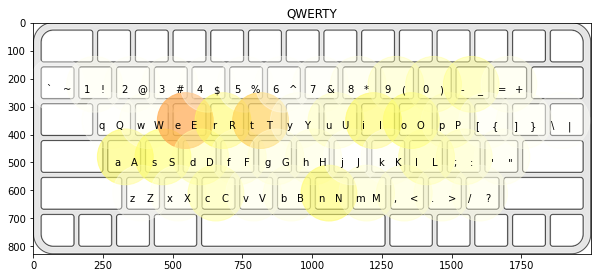

In [152]:
HeatmapLayout(qwertyLayout, allChars, charCountCSV, double=True)
plt.gca().set_title('QWERTY')

Text(0.5, 1.0, 'Dvorak')

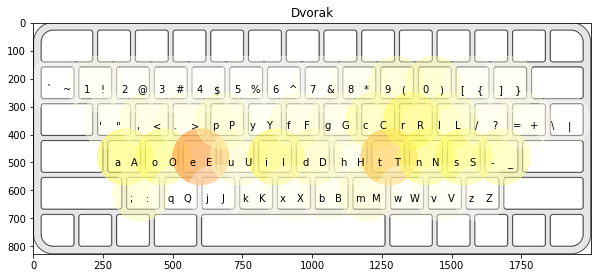

In [153]:
HeatmapLayout(dvorak, allChars, charCountCSV, double=True)
plt.gca().set_title('Dvorak')

Text(0.5, 1.0, 'Programmer Dvorak')

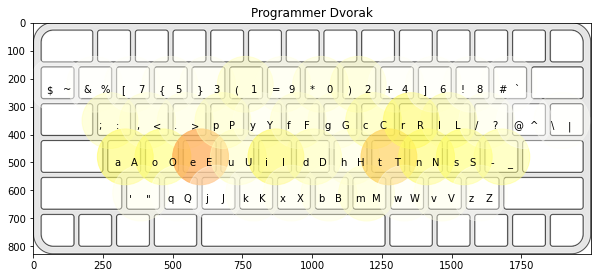

In [154]:
HeatmapLayout(programmerDvorak, allChars, charCountCSV, double=True)
plt.gca().set_title('Programmer Dvorak')

Text(0.5, 1.0, 'Solution')

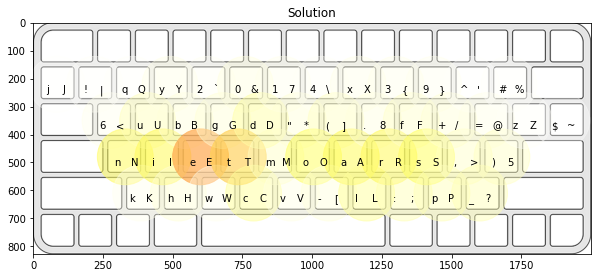

In [155]:
HeatmapLayout(sol['X'], allChars, charCountCSV, double=True)
plt.gca().set_title('Solution')